In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!nvidia-smi
!pip install -U git+https://github.com/qubvel/efficientnet

In [3]:
%tensorflow_version 2.x

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow.keras.callbacks as cb
import tensorflow.keras.layers as L
import tensorflow.keras as K
import tensorflow as tf

import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, zipfile

# tf.keras.backend.set_learning_phase(True)

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 100
NUM_CLASSES = 6
train_images_path = '/content/train_images'       # 資料路徑
test_images_path = '/content/test_images'         # 資料路徑

# 資料載入

In [5]:
folder = '/content/drive/My Drive/Colab Notebooks/AOI/AOI'

if not os.path.exists(train_images_path):
    f = zipfile.ZipFile(os.path.join(folder, 'train_images.zip'))
    f.extractall("./")

if not os.path.exists(test_images_path):
    f = zipfile.ZipFile(os.path.join(folder, 'test_images.zip'))
    f.extractall("./")

train_df = pd.read_csv(os.path.join(folder, 'train.csv'))
test_df = pd.read_csv(os.path.join(folder, 'test.csv'))

train_df['Label'] = train_df['Label'].astype('str')

# 資料增強

In [6]:
# [-1, 1]
def preprocess_fn1(im_array):
    return im_array / 127.5 -1

trn_dagen = ImageDataGenerator(preprocessing_function= preprocess_fn1,
                            #    rotation_range=40,
                            #    horizontal_flip=True,
                            #    vertical_flip=True,
                            #    width_shift_range=0.1, 
                            #    height_shift_range=0.1, 
                            #    shear_range=0.1, 
                            #    zoom_range=0.1, 
                               validation_split=0.05)

trn_gen = trn_dagen.flow_from_dataframe(train_df,
                                        directory=train_images_path,
                                        x_col="ID",
                                        y_col="Label",
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        class_mode="sparse",
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        subset='training')

val_gen = trn_dagen.flow_from_dataframe(train_df,
                                        directory=train_images_path,
                                        x_col="ID",
                                        y_col="Label",
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        class_mode="sparse",
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        subset='validation')

Found 2402 validated image filenames belonging to 6 classes.
Found 126 validated image filenames belonging to 6 classes.


# Callback 設置、模型建立、模型編譯、模型訓練

In [7]:
# 衰退學習率 (Learning rate)
rl_callback = cb.ReduceLROnPlateau(monitor   = "val_loss", 
                                   factor    = 0.5,
                                   patience  = 3, 
                                   verbose   = 0, 
                                   min_delta = 1e-4, 
                                   min_lr    = 1e-6)

es_callback = cb.EarlyStopping(patience=10, 
                               restore_best_weights=True)
callbacks = [
             rl_callback, 
             es_callback
             ]

STEP_SIZE_TRAIN = trn_gen.n // NUM_EPOCHS
STEP_SIZE_VALID = val_gen.n // NUM_EPOCHS

net = efn.EfficientNetB7(input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3),
                         weights= 'noisy-student',
                         include_top= False)

for layer in net.layers: 
    layer.trainable = True

x = net.output
x = L.GlobalAveragePooling2D()(x)
out = L.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=net.input, outputs=out)

In [8]:
# from tensorflow.keras.utils import to_categorical, plot_model

# print(len(model.layers))
# model.summary()
# plot_model(model)

# 模型編譯
    categorical crossentropy 多分類, 2 個類別以上
    Sparse 會自動做 one-hot encoding
     

In [9]:
from tensorflow_addons.optimizers import Lookahead
from tensorflow_addons.optimizers import RectifiedAdam

opt = K.optimizers.Adam()
Ranger = Lookahead(opt, sync_period=6, slow_step_size=0.5)

model.compile(loss=K.losses.SparseCategoricalCrossentropy(), 
              optimizer=Ranger, 
              metrics=[K.metrics.SparseCategoricalAccuracy()])

# 模型訓練

In [ ]:
history = model.fit(trn_gen,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs= NUM_EPOCHS,
                    verbose= 2, 
                    validation_data= val_gen,
                    validation_steps= STEP_SIZE_VALID,
                    callbacks= callbacks)

# 觀察 Accuracy、Loss

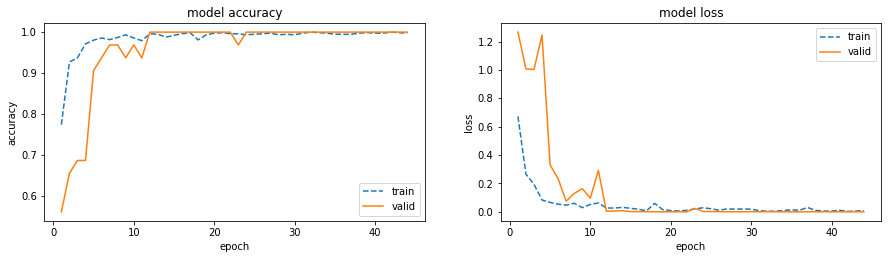

In [11]:
epochs = range(1, len(history.history['sparse_categorical_accuracy']) + 1)

plt.figure(1, figsize = (15, 8)) 

plt.subplot(221)
plt.plot(epochs, history.history['sparse_categorical_accuracy'], linestyle='--')
plt.plot(epochs, history.history['val_sparse_categorical_accuracy'])
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.title('model accuracy')  
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(epochs, history.history['loss'], linestyle='--')
plt.plot(epochs, history.history['val_loss'], label = 'Validation Loss')
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

# 預測

In [12]:
txt_dagen = ImageDataGenerator(preprocessing_function= preprocess_fn1)

txt_gen = txt_dagen.flow_from_dataframe(test_df,
                                        directory=test_images_path,
                                        x_col="ID",
                                        y_col="Label",
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        class_mode=None,
                                        batch_size=BATCH_SIZE,
                                        shuffle=None)

result = model.predict(txt_gen).argmax(axis=1)

Found 10142 validated image filenames.


In [13]:
test_df['Label'] = result
test_df.to_csv(os.path.join('/content/drive/My Drive', 'Result.csv'), encoding="utf8", index=False)